In [65]:
import networkx as nx
import numpy as np
import pandas as pd
from pyvis.network import Network
import matplotlib.pyplot as plt
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from scipy.cluster import hierarchy
import random

MINIMAL_CONN_CNT = 50

In [66]:
def open_data(filename: str = "./data.csv", named_row: bool = False) -> pd.DataFrame:
    if named_row:
        data = pd.read_csv(filename, index_col=0)
    else:
        data = pd.read_csv(filename)

    return data

def create_graph(matrix: pd.DataFrame):
    val = matrix.values.tolist()
    net = Network(directed=True)
    ret_nx_net = nx.Graph()
    names = list(matrix.columns.values)

    for x in names:
        net.add_node(x, label=x)
        ret_nx_net.add_node(x, label=x)

    for x, valx in enumerate(val):
        for y, valy in enumerate(val):
            if (type(val[x][y]) != int):
                # print(f"{names[x]} !+! {val[x][y]} !+! {names[y]}")
                continue
            elif (val[x][y] < MINIMAL_CONN_CNT):
                continue
            else:
                ret_nx_net.add_edge(names[x], names[y], weight=val[x][y])
                net.add_edge(names[x], names[y], weight=val[x][y])

    net.toggle_physics(False)
    net.show_buttons(filter_=["physics"])
    net.save_graph('mygraph.html')

    return ret_nx_net

def draw(subset: list, original: nx.Graph, title: str, tofile = False):
    for idx,x in enumerate(subset):
        subgraph = original.subgraph(x)
        plt.figure()
        nx.draw(subgraph, with_labels=True, node_color=f"C{idx}", node_size=300)
        plt.title(f"{title} {idx+1}")
        plt.show()

def draw_colores(subset: list, original: nx.Graph, tofile = False):
    pos = nx.spring_layout(G, seed=3113794652)
    subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
    ]
    
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
    for x in subset:
        nx.draw_networkx_nodes(original, pos, nodelist=x, node_color=random.choice(subset_color), **options)

    # edges
    nx.draw_networkx_edges(original, pos, width=1.0, alpha=0.5)
    plt.tight_layout()
    plt.axis("off")
    plt.show()

In [67]:
data = open_data("./matrix.csv")
G = create_graph(matrix=data)

# Wydzielić podgrupy takie,
- jak kliki (zbiór wierzchołków, w którym każda para połączona jest krawędzią)
- moduły (obszary, wewnątrz których gęstość połączeń jest większa niż między nimi)


In [68]:
cliques = list(nx.find_cliques(G))
show_details = False
print(f"Ilość klik: {len(cliques)}")
largest_idx = cliques.index(max(cliques, key=lambda x: len(x)))
print()
size = max([len(x) for x in list(nx.find_cliques(G))])
print(f"Największa klika ma rozmiar: {size}")
print(cliques[largest_idx])

if show_details:
    print("Kliki:")
    draw(cliques[0:10], G, "Klika")


#Moduły:
print("---Moduły---")
modularity_communities = list(greedy_modularity_communities(G))
print(f"Ilosc modułów: {len(modularity_communities)}")
if show_details:
    draw(modularity_communities, G, "Modules")

Ilość klik: 234

Największa klika ma rozmiar: 9
['Rondo Reagana', 'Nowowiejska / Wyszyńskiego', 'Drobnera / Plac Bema', 'Plac Dominikański (Galeria Dominikańska)', 'Drobnera / Dubois', 'Wita Stwosza / Szewska', 'Nowowiejska / Jedności Narodowej', 'Zwycięska / Ołtaszyńska', 'Rynek']
---Moduły---
Ilosc modułów: 5


# 3. Metody podziałowe:

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In [76]:
import itertools
show_details = False
gn_communities = community.girvan_newman(G)
print("Metoda podziałowa - Girvan-Newman:")
print(tuple(sorted(c) for c in next(gn_communities)))
if show_details:
    draw(gn_communities[0:5], G, "GN-communities")

Metoda podziałowa - Girvan-Newman:
(['Unnamed: 0'], ['Aleja Kromera', 'Borowska (Uniw. Szpital Kliniczny)', 'Drobnera / Dubois', 'Drobnera / Plac Bema', 'Dworzec Główny ', 'Dyrekcyjna / Borowska (Wroclavia)', 'Grabiszyńska / Stalowa', 'Kamienna / Borowska (Aquapark)', 'Kazimierza Wielkiego (Helios)', 'Kościuszki / Komuny Paryskiej / Zgodna', 'Kościuszki / Pułaskiego', 'Krzycka / Aleja Karkonoska (Park Południowy)', 'Legnicka (Park Magnolia)', 'Legnicka / Wejherowska', 'Legnicka / Zachodnia\xa0', 'Leśnica - pętla tramwajowa', 'Norwida / Wyspiańskiego (PWr)', 'Nowowiejska / Górnickiego', 'Nowowiejska / Jedności Narodowej', 'Nowowiejska / Wyszyńskiego', 'Oporów (pętla tramwajowa)', 'Pereca / Grabiszyńska', 'Plac Dominikański (Galeria Dominikańska)', 'Plac Grunwaldzki (DS Ołówek)', 'Plac Kościuszki (Renoma)', 'Plac Legionów', 'Plac Powstańców Śląskich', 'Plac Świętego Macieja / Trzebnicka', 'Poniatowskiego / Oleśnicka', 'Powstańcow Śląskich / Aleja Hallera', 'Robotnicza / Fabryczna', 'Rond

 # 4. Porównanie metody aglomeracyjnej i metod podziałowych za pomocą modularności

In [77]:
matrix_dst = nx.to_numpy_array(G)
Z = hierarchy.linkage(matrix_dst, method='complete')
k = 6  # Liczba klastrów
partition_agglomerative = hierarchy.cut_tree(Z, n_clusters=k).flatten()
# print(partition_agglomerative)
# Tworzenie listy społeczności na podstawie wyniku podziału
communities_agglomerative = [set() for _ in range(k)]
names = list(G.nodes)
for node, community_id in enumerate(partition_agglomerative):
    communities_agglomerative[community_id].add(names[node])

# Clauset-Newman-Moore z zadania 1
# Bliżej 1 - lepiej, bliżej 0 -> lepiej losować
# Obliczenie modularności dla społeczności wygenerowanych przez metodę aglomeracyjną
partition_gn = next(gn_communities)
modularity_agglomerative = community.modularity(G, communities_agglomerative)
modularity_gn = community.modularity(G, partition_gn)
modularity_greedy = community.modularity(G, greedy_modularity_communities(G))
print(f"Modularność - Metoda aglomeracyjna: {modularity_agglomerative}") #louvain
print(f"Modularność - Metoda podziałowa (Girvan-Newman): {modularity_gn}")
print(f"Modularność - CNM greedy modularity maximization: {modularity_greedy}")



Modularność - Metoda aglomeracyjna: 0.024465538264619016
Modularność - Metoda podziałowa (Girvan-Newman): -0.00036196031711669785
Modularność - CNM greedy modularity maximization: 0.223524993673883


# 5. Dokonać podziału sieci złożonej na dwa rozłączne zbiory węzłów, stosując metodę podziału spektralnego.



Podział spektralny - Zbiór 1: ['Szewska / Kazimierza Wielkiego\xa0', 'Wita Stwosza / Szewska', 'Dworzec Główny ', 'Plac Legionów', 'Nowowiejska / Jedności Narodowej', 'Drobnera / Plac Bema', 'Drobnera / Dubois', 'Kazimierza Wielkiego (Helios)', 'Zwycięska / Ołtaszyńska', 'Rondo Reagana', 'Rynek', 'Wyszyńskiego / Szczytnicka', 'Kościuszki / Pułaskiego', 'Legnicka / Zachodnia\xa0', 'Robotnicza / Fabryczna', 'Dyrekcyjna / Borowska (Wroclavia)', 'Kościuszki / Komuny Paryskiej / Zgodna', 'Plac Świętego Macieja / Trzebnicka', 'Legnicka (Park Magnolia)', 'Norwida / Wyspiańskiego (PWr)', 'Świdnicka / Piłsudskiego (Hotel Scandic)', 'Zaporoska / Grabiszyńska', 'Nowowiejska / Wyszyńskiego', 'Plac Dominikański (Galeria Dominikańska)', 'Sienkiewicza / Piastowska', 'Borowska (Uniw. Szpital Kliniczny)', 'Traugutta / Kościuszki', 'Legnicka / Wejherowska', 'Sienkiewicza / Wyszyńskiego', 'Żeromskiego / Daszyńskiego', 'Plac Grunwaldzki (DS Ołówek)', 'Nowowiejska / Górnickiego', 'Grabiszyńska / Stalowa']


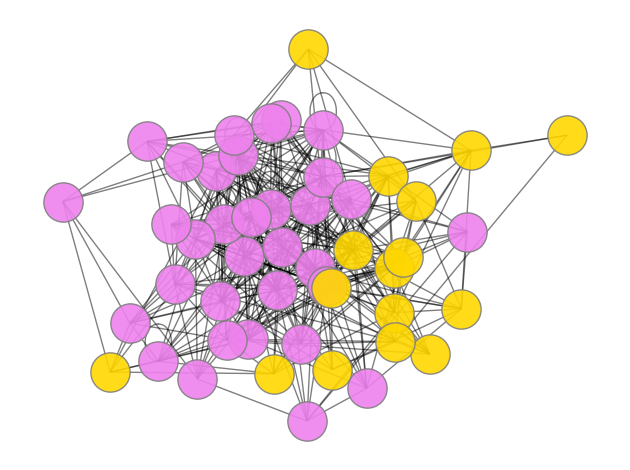

In [71]:
# Obliczanie macierzy Laplace'a
show_details = False
from sklearn.cluster import spectral_clustering, KMeans

G.remove_nodes_from(list(nx.isolates(G)))
matrix = nx.to_numpy_array(G)
pos = nx.spring_layout(G, seed=3113794652)  

# Podział na dwa zbiory węzłów za pomocą metody podziału spektralnego
num_clusters = 2
labels = spectral_clustering(matrix, n_clusters=num_clusters, eigen_solver='arpack')

# Przypisanie węzłów do dwóch zbiorów na podstawie wyników podziału spektralnego
subset1 = [names[node] for node, label in enumerate(labels) if label == 0]
subset2 = [names[node] for node, label in enumerate(labels) if label == 1]

print("Podział spektralny - Zbiór 1:", subset1)
print("Podział spektralny - Zbiór 2:", subset2)

draw_colores([subset1, subset2], G)

{'icoord': [[5.0, 5.0, 15.0, 15.0], [35.0, 35.0, 45.0, 45.0], [25.0, 25.0, 40.0, 40.0], [85.0, 85.0, 95.0, 95.0], [105.0, 105.0, 115.0, 115.0], [125.0, 125.0, 135.0, 135.0], [155.0, 155.0, 165.0, 165.0], [145.0, 145.0, 160.0, 160.0], [130.0, 130.0, 152.5, 152.5], [110.0, 110.0, 141.25, 141.25], [175.0, 175.0, 185.0, 185.0], [195.0, 195.0, 205.0, 205.0], [265.0, 265.0, 275.0, 275.0], [255.0, 255.0, 270.0, 270.0], [245.0, 245.0, 262.5, 262.5], [235.0, 235.0, 253.75, 253.75], [225.0, 225.0, 244.375, 244.375], [215.0, 215.0, 234.6875, 234.6875], [200.0, 200.0, 224.84375, 224.84375], [285.0, 285.0, 295.0, 295.0], [305.0, 305.0, 315.0, 315.0], [290.0, 290.0, 310.0, 310.0], [325.0, 325.0, 335.0, 335.0], [345.0, 345.0, 355.0, 355.0], [330.0, 330.0, 350.0, 350.0], [375.0, 375.0, 385.0, 385.0], [405.0, 405.0, 415.0, 415.0], [395.0, 395.0, 410.0, 410.0], [425.0, 425.0, 435.0, 435.0], [402.5, 402.5, 430.0, 430.0], [380.0, 380.0, 416.25, 416.25], [365.0, 365.0, 398.125, 398.125], [340.0, 340.0, 381

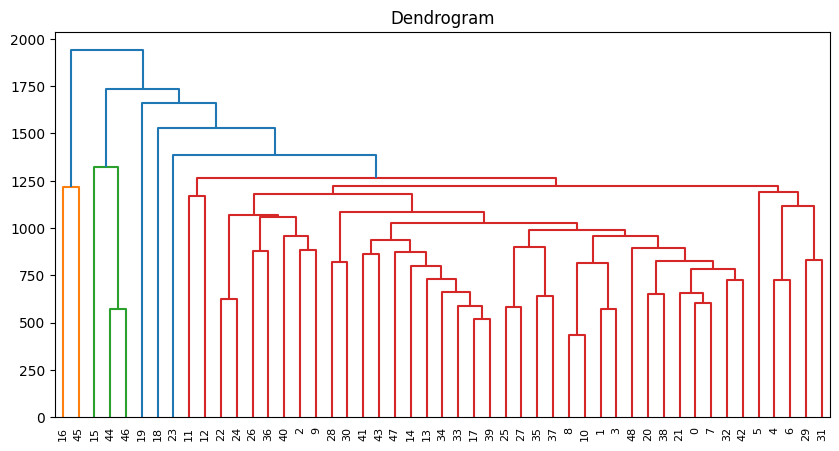

In [72]:
distance_matrix = nx.to_numpy_array(G)
Z = hierarchy.linkage(distance_matrix, method='complete')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z)
print(dn)
plt.title('Dendrogram')
plt.show()